In [2]:
using Revise, Statistics, LaTeXStrings, DSP, StatsBase
using Formatting, MAT, ControlSystems, FFTW
using CairoMakie, Makie
using ColorSchemes
import ColorSchemes: nord, tab10, Dark2_8

printx(x,N) = sprintf1("%.$(N)f",x)


# fg = :black  # nord[5]
# gg = :grey   # nord[3]
fg = nord[5]
gg = nord[3]
bg = :transparent

cscheme = Dark2_8

set_theme!(Theme(
    fontsize = 20,
    palette = ( color = cscheme,),
    markerstrokewidth=0.1,
    Axis = (
        backgroundcolor = bg,
        xtickcolor = fg, ytickcolor = fg,
        xgridcolor = gg, ygridcolor = gg,
        xlabelcolor = fg, ylabelcolor = fg,
        xticklabelcolor = fg, yticklabelcolor = fg,
        topspinecolor = fg, bottomspinecolor = fg,
        leftspinecolor = fg, rightspinecolor = fg,
        titlecolor = fg,
    ),
    Legend = (
        bgcolor = bg,
        labelcolor = fg, titlecolor = fg,
        framevisible = false, margin=(0,0,0,0)
    )
))

In [165]:
# function covpred(x, p, r)
#     N = length(x)
#     X = zeros(N+p, p)
#     for i=1:p
#         X[i:i+N-1,i] = x
#     end
#     X = X[p:N-1,:]
#     b = x[p+1:N]
#     a = [1; -X \ b]
#     err = mean((x - filt(1.0, a, [1; zeros(N-1)])).^2)
#     return [a, err]
# end

# function corrpred(x, p, r)
#     N = length(x)
#     X = zeros(N+p, p+1)
#     for i=1:p+1
#         X[i:i+N-1,i] = x
#     end
#     a =  X \ [x[1]; zeros(N+p-1)]
#     err = mean((x - filt(1.0, a, [1; zeros(N-1)])).^2)
#     return [a, err]
# end
function corrpred(x, p, r)
    N = length(x)
    X = zeros(N+p, p)
    for i=1:p
        X[i:i+N-1,i] = x
    end
    b = [zeros(p);x]
    a = [1; vec(reverse(-X \ b))]
    err = mean((x - filt(1.0, a, [1; zeros(N-1)])).^2)
    return [a, err]
end

function covpred(x, p, r)
    N = length(x)
    X = zeros(N+p, p)
    for i=1:p
        X[i:i+N-1,i] = x
    end
    X = X[p:N-1,:] 
    b = x[p+1:N]
    a = [ 1; -X \ b ]
    err = mean((x - filt(1.0, a, [1; zeros(N-1)])).^2)
    return [a, err]
end

covpred (generic function with 1 method)

In [166]:
x = filt(1.0, [1,0.2,0.3], [1; zeros(100)])
@show corrpred(x, 2, 0);
@show covpred(x, 2, 0);

corrpred(x, 2, 0) = Any[[1.0, 0.20000000000000004, 0.29999999999999993], 1.5345506603075699e-34]
covpred(x, 2, 0) = Any[[1.0, 0.19999999999999998, 0.29999999999999993], 5.611008013959383e-35]


In [167]:
ARdata = matread("ARdata.mat")
x1 = ARdata["y1"]
x2 = ARdata["y2"]
x3 = ARdata["y3"]
a1 = vec(real(ARdata["a1"]))

4-element Vector{Float64}:
  1.0
 -1.9099026535611552
  1.3989016800967666
 -0.4949

In [169]:
@show a1
@show corrpred(x1, 3, 0);
@show covpred(x1, 3, 0);

a1 = [1.0, -1.9099026535611552, 1.3989016800967666, -0.4949]
corrpred(x1, 3, 0) = Any[[1.0, -1.1126964986083698, 0.12918930855342747, 0.006133164604406779], 21.163289952922604]
covpred(x1, 3, 0) = Any[[1.0, -1.9099026535611545, 1.3989016800967649, -0.494899999999999], 8.898202321888412]


P = tf([1.0], a1) = TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
                             1.0
-------------------------------------------------------------
1.0s^3 - 1.9099026535611552s^2 + 1.3989016800967666s - 0.4949

Continuous-time transfer function model


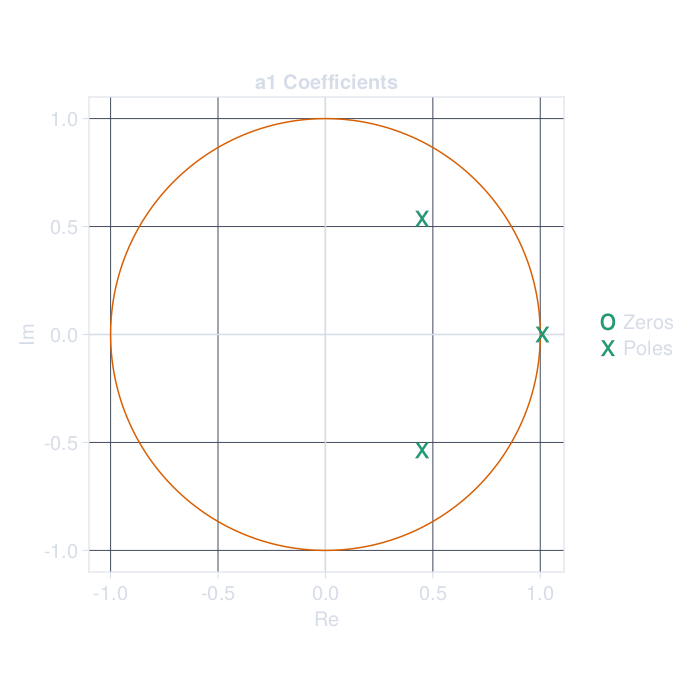

In [187]:
@show P = tf([1.0], a1)

function ucircle!(ax::Axis; color=cscheme[1], zero_splines=true)
    if zero_splines
        vlines!(ax, 0, color=fg)
        hlines!(ax, 0, color=fg)
    end
    unit_circle = exp.(1im*(0:0.01:2π))
    lines!(ax, real(unit_circle), imag(unit_circle), color=cscheme[2])
end

function zplane!(ax::Axis, sys::LTISystem; color=cscheme[1], markersize=30)
    z = tzeros(sys)
    p = poles(sys)
    return [
        scatter!(ax, real(z), imag(z), marker='o', color=color, markersize=markersize),
        scatter!(ax, real(p), imag(p), marker='x', color=color, markersize=markersize)
    ]
end

F = Figure(backgroundcolor=bg, resolution=(700,700))
ax = Axis(F[1,1], aspect=AxisAspect(1), xlabel="Re", ylabel="Im", title="a1 Coefficients")
ucircle!(ax)
sc_z, sc_p = zplane!(ax, P)
Legend(F[1,2], [sc_z, sc_p], ["Zeros", "Poles"])
save("1.pdf", F)
F

(a1_corr, err1_corr) = corrpred(x1, 3, 1) = Any[[1.0, -1.1126964986083698, 0.12918930855342747, 0.006133164604406779], 21.163289952922604]
(a1_cov, err1_cov) = covpred(x1, 3, 1) = Any[[1.0, -1.9099026535611545, 1.3989016800967649, -0.494899999999999], 8.898202321888412]


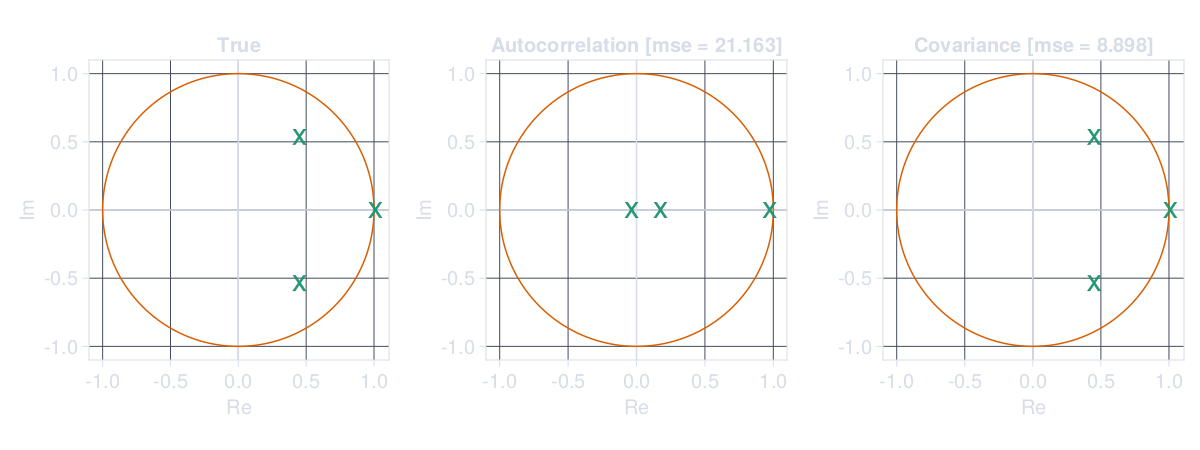

In [186]:
@show a1_corr, err1_corr = corrpred(x1, 3, 1)
@show a1_cov, err1_cov   = covpred(x1, 3, 1)

F = Figure(backgroundcolor=bg, resolution=(1200,450))
ax1 = Axis(F[1,1], xlabel="Re", ylabel="Im", aspect=AxisAspect(1), title="True")
ax2 = Axis(F[1,2], xlabel="Re", ylabel="Im", aspect=AxisAspect(1), title="Autocorrelation [mse = $(printx(err1_corr, 3))]")
ax3 = Axis(F[1,3], xlabel="Re", ylabel="Im", aspect=AxisAspect(1), title="Covariance [mse = $(printx(err1_cov, 3))]")
ucircle!(ax1); zplane!(ax1, tf([1.0], a1))
ucircle!(ax2); zplane!(ax2, tf([1.0], a1_corr))
ucircle!(ax3); zplane!(ax3, tf([1.0], a1_cov))
save("2.pdf", F)
F

(a2_corr, err2_corr) = corrpred(x2, 3, 1) = Any[[1.0, -1.3775188403561074, 0.4600142950149413, 0.015401381847379235], 114.12341561753004]
(a2_cov, err2_cov) = covpred(x2, 3, 1) = Any[[1.0, -1.9185313001257398, 1.3425206524308064, -0.38761773960672513], 121.81561011332171]


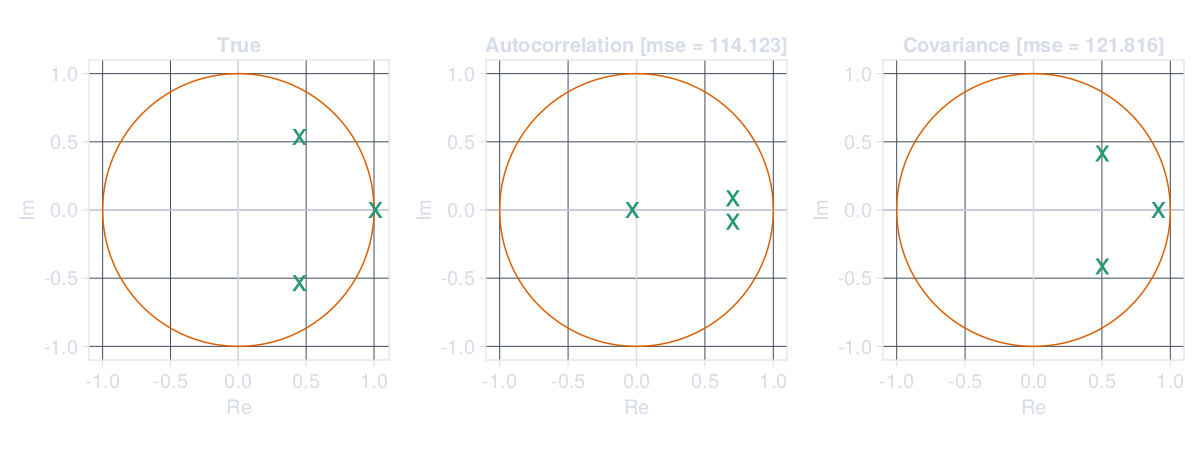

In [173]:
@show a2_corr, err2_corr = corrpred(x2, 3, 1)
@show a2_cov, err2_cov   = covpred(x2, 3, 1)

F = Figure(backgroundcolor=bg, resolution=(1200,450))
ax1 = Axis(F[1,1], xlabel="Re", ylabel="Im", aspect=AxisAspect(1), title="True")
ax2 = Axis(F[1,2], xlabel="Re", ylabel="Im", aspect=AxisAspect(1), title="Autocorrelation [mse = $(printx(err2_corr, 3))]")
ax3 = Axis(F[1,3], xlabel="Re", ylabel="Im", aspect=AxisAspect(1), title="Covariance [mse = $(printx(err2_cov, 3))]")
ucircle!(ax1); zplane!(ax1, P)
ucircle!(ax2); zplane!(ax2, tf([1.0], a2_corr))
ucircle!(ax3); zplane!(ax3, tf([1.0], a2_cov))
save("3.pdf", F)
F

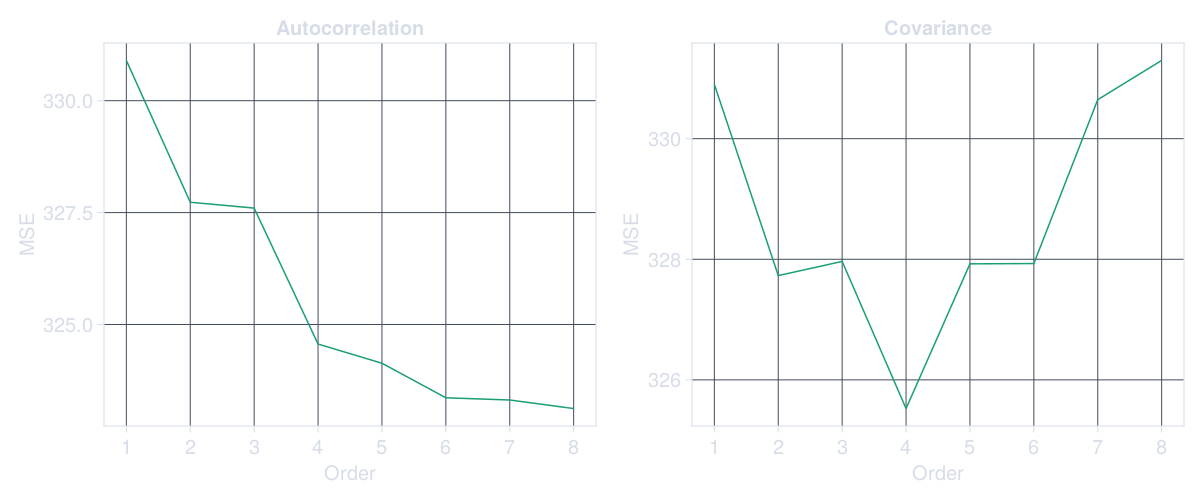

In [175]:
orders = 1:8

corr_errs = zeros(length(orders))
cov_errs = zeros(length(orders))
for (i,o) in enumerate(orders)
    _, corr_errs[i] = corrpred(x3, o, 0)
    _, cov_errs[i] = covpred(x3, o, 0)
end

F = Figure(backgroundcolor=bg, resolution=(1200, 500))
ax1 = Axis(F[1,1], xlabel="Order", ylabel="MSE", title="Autocorrelation", xticks=orders)
ax2 = Axis(F[1,2], xlabel="Order", ylabel="MSE", title="Covariance", xticks=orders)
lines!(ax1, orders, corr_errs)
lines!(ax2, orders, cov_errs)
save("4.pdf",F)
F

# Ex. 1.2

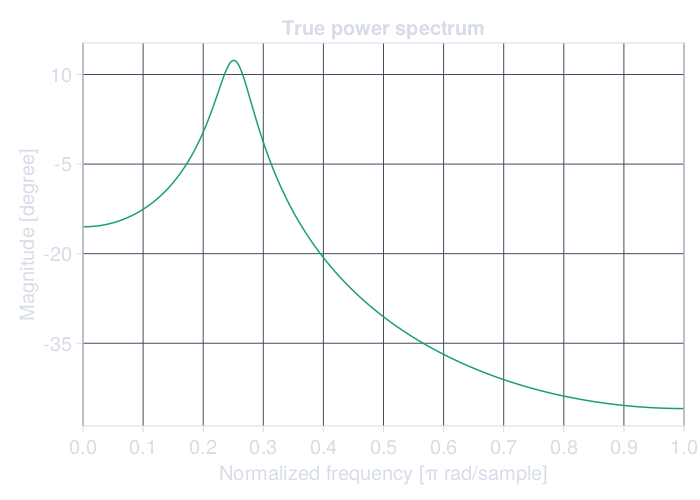

In [176]:
b = 5
a = [ 1.0, -1.3, 0.845 ]

N = 1000
# x = randn(N)
x = [1; zeros(N-1)]
h = filt(b, a, x)

H = fftshift(fft(h))
H_true = H[end÷2:end]
P_h_true = abs.(H_true.^2)
P_h_true /= length(P_h_true)

F = Figure(backgroundcolor=bg, resolution=(700,500))
ax = Axis(F[1,1], title="True power spectrum",
    xlabel="Normalized frequency [π rad/sample]",
    ylabel="Magnitude [degree]",
    xticks=0:0.1:1, yticks=-65:15:20)
lines!(ax, range(0,1,N÷2+1), amp2db.(P_h_true))
xlims!(0,1)
# ylims!(-67, 7)
save("5.pdf", F)
F

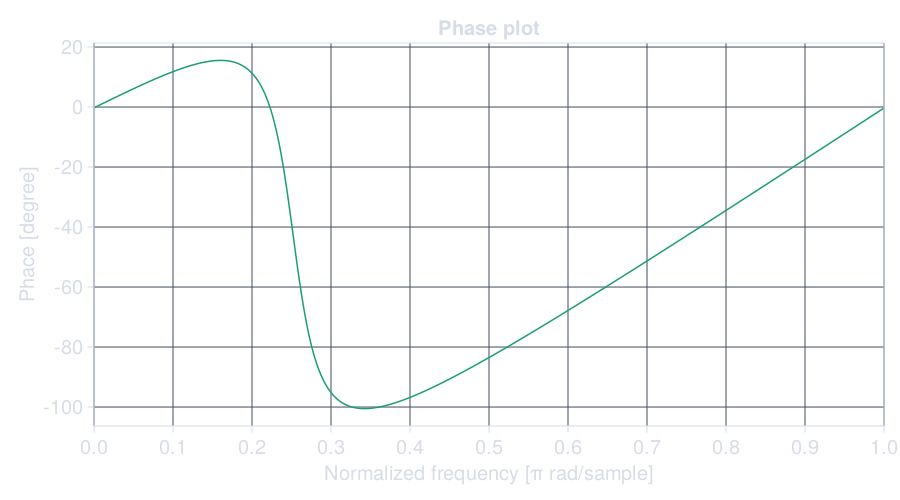

In [177]:
F = Figure(backgroundcolor=bg, resolution=(900,500))
ax = Axis(F[1,1], title="Phase plot", 
    xlabel="Normalized frequency [π rad/sample]",
    ylabel="Phace [degree]",
    xticks=0:0.1:1, yticks=-120:20:20)
xlims!(0,1)
lines!(ax, range(0,1,N÷2+1), rad2deg.(atan.(imag(H_true), real(H_true))))
save("6.pdf",F)
F

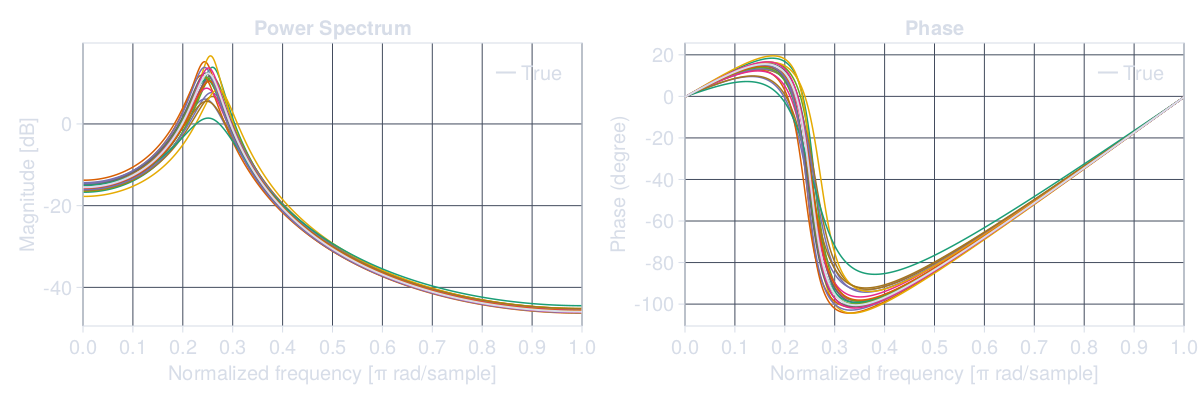

In [189]:
N = 1000
# x = [1; zeros(N-1)]
F = Figure(backgroundcolor=bg, resolution=(1200,400))
ax1 = Axis(F[1,1], title="Power Spectrum", 
    xlabel="Normalized frequency [π rad/sample]",
    ylabel="Magnitude [dB]",
    xticks=0:0.1:1
)
ax2 = Axis(F[1,2], title="Phase", 
    xlabel="Normalized frequency [π rad/sample]",
    ylabel="Phase (degree)",
    xticks=0:0.1:1, yticks=-120:20:20
)

as = zeros(20, 3)

for i = 1:20
    x = randn(N)
    h = filt(b, a, x)
    h_samples = h[20:20+255]
    a_corr, err = corrpred(h_samples, 2, 1)
    as[i, :] = a_corr
    h = filt(b, a_corr, [1; zeros(N-1)])

    H = fftshift(fft(h))
    H = H[end÷2:end]
    P_h = abs.(H.^2)
    P_h /= length(P_h)

    lines!(ax1, range(0,1,N÷2+1), amp2db.(P_h))
    lines!(ax2, range(0,1,N÷2+1), rad2deg.(atan.(imag(H), real(H))))
end
l1 = lines!(ax1, range(0,1,length(P_h_true)), amp2db.(P_h_true), color=fg, linewidth=2)
xlims!(ax1,0,1)
l2 = lines!(ax2, range(0,1,length(H_true)), rad2deg.(atan.(imag(H_true), real(H_true))), color=fg, linewidth=2)
xlims!(ax2,0,1)
axislegend(ax1, [l1], ["True"])
axislegend(ax2, [l2], ["True"])
save("7.pdf", F)
F


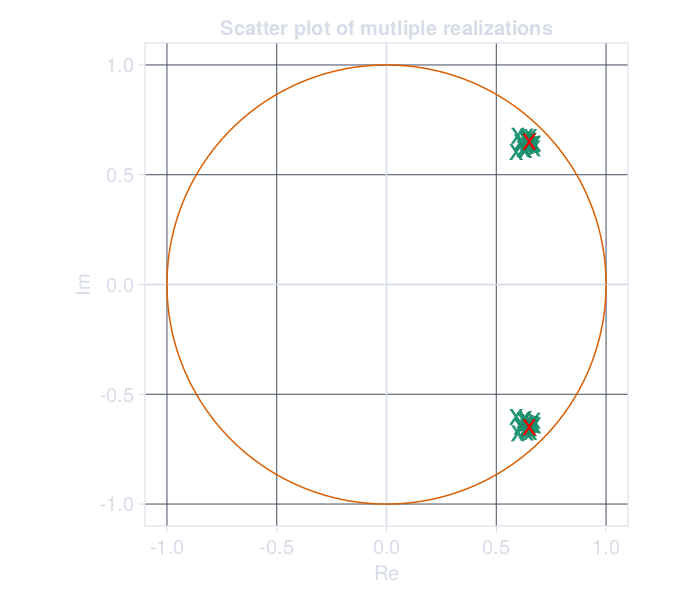

In [190]:
F = Figure(backgroundcolor=bg, resolution=(700,600))
ax = Axis(F[1,1], aspect=AxisAspect(1), ylabel="Im", xlabel="Re", title="Scatter plot of mutliple realizations")
ucircle!(ax)
for r ∈ axes(as, 1)
    zplane!(ax, tf(b, as[r,:]))
end
zplane!(ax, tf(b, a), color=:red)
save("8.pdf", F)
F

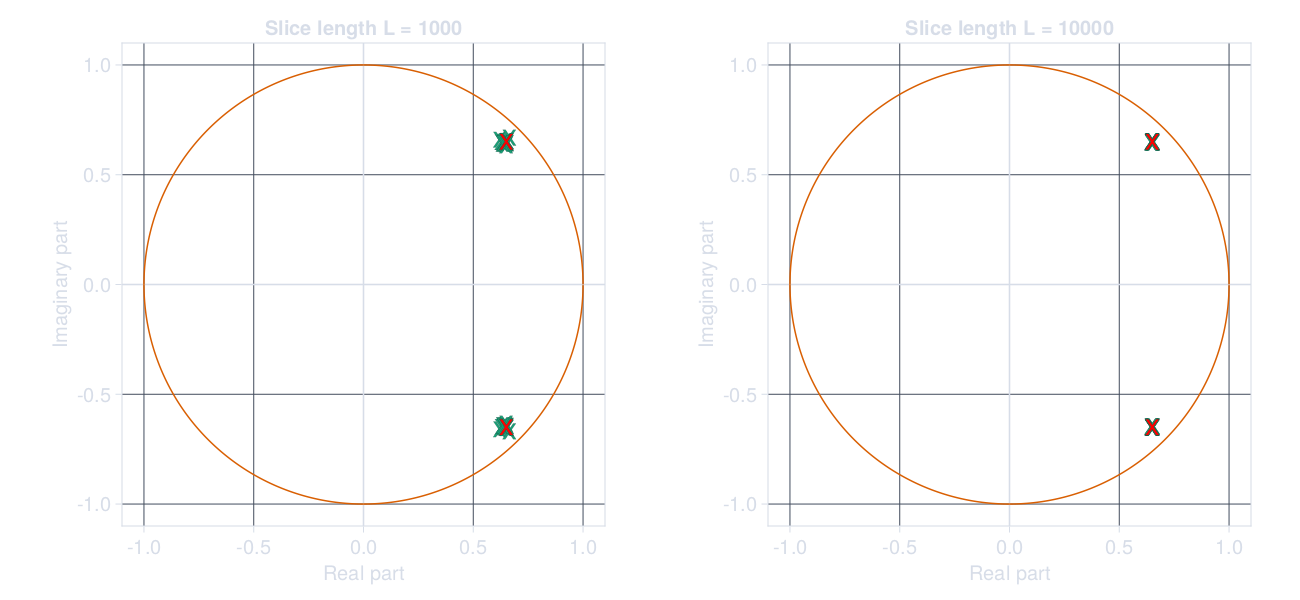

In [192]:
N = 10_000
# x = [1; zeros(N-1)]
F = Figure(backgroundcolor=bg, resolution=(1300,600))
ax1 = Axis(F[1,1], title="Slice length L = 1000", aspect=AxisAspect(1),
    xlabel="Real part",
    ylabel="Imaginary part",
)
ax2 = Axis(F[1,2], title="Slice length L = 10000", aspect=AxisAspect(1),
    xlabel="Real part",
    ylabel="Imaginary part",
)
as = zeros(20, 3)
ucircle!(ax1)
ucircle!(ax2)

for i = 1:20
    x = randn(N)
    h = filt(b, a, x)
    h_samples = h[20:20+1000]
    h_samples2 = h[20:end]
    a_corr, _ = corrpred(h_samples, 2, 1)
    a_corr2, _ = corrpred(h_samples2, 2, 1)

    zplane!(ax1, tf(b, a_corr))
    zplane!(ax2, tf(b, a_corr2))
end
zplane!(ax1, tf(b,a), color=:red)
zplane!(ax2, tf(b,a), color=:red)
save("9.pdf", F)
F

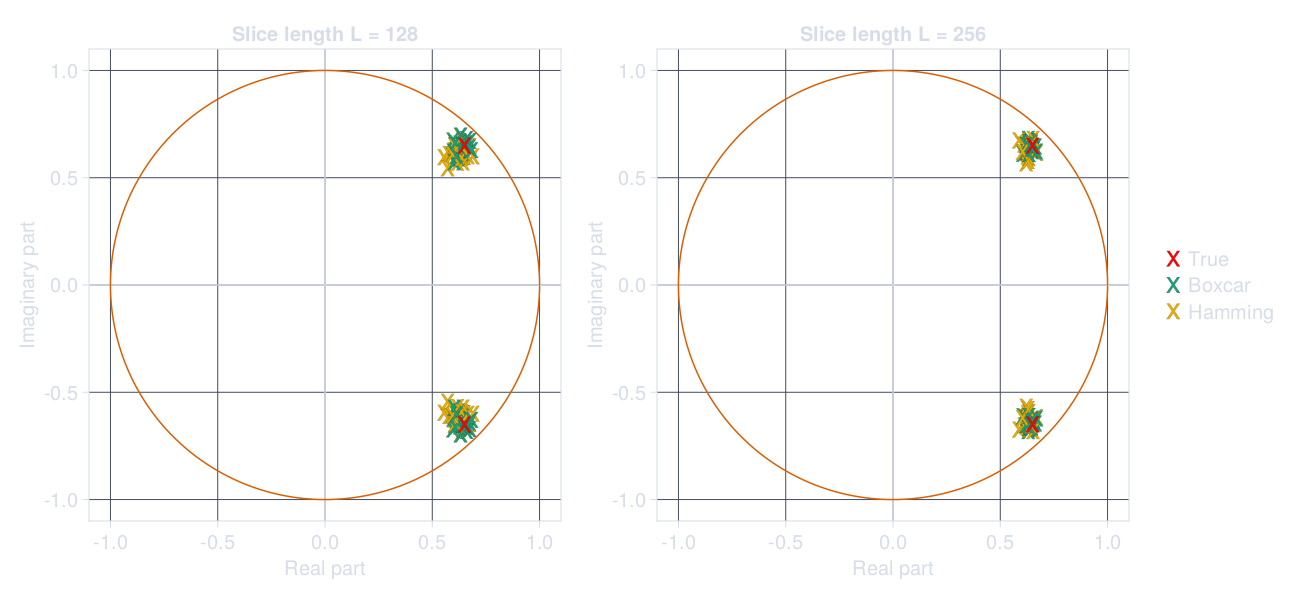

In [195]:
N = 1000
# x = [1; zeros(N-1)]
F = Figure(backgroundcolor=bg, resolution=(1300,600))
s1 = s2 = s3 = nothing
for (k,l) in enumerate([128, 256])

    ax = Axis(F[1, k], aspect=AxisAspect(1), xlabel="Real part", ylabel="Imaginary part", title="Slice length L = $l")
    ucircle!(ax)
    for i = 1:20
        x = randn(N)
        h1 = filt(b, a, x)
        h2 = filt(b, a, x.*hamming(N))
        h_samples = h1[20:20+l-1]
        h_samples2 = h2[20:20+l-1]
        a_corr, _ = corrpred(h_samples, 2, 1)
        a_corr2, _ = corrpred(h_samples2, 2, 1)

        _,s2 = zplane!(ax, tf(b, a_corr2), color=cscheme[6])
        _,s1 = zplane!(ax, tf(b, a_corr))
    end
    _,s3 = zplane!(ax, tf(b,a), color=:red)
end
Legend(F[1,3], [s3, s1, s2], ["True", "Boxcar", "Hamming"])
save("10.pdf", F)
F